In [1]:
import os
if os.path.basename(os.getcwd()) != 'Learning-Dynamic-Systems': os.chdir(".\\..") 

import numpy as np
import matplotlib.pyplot as plt
import logging

from indirect_identification.sps_indirect import SPS_indirect_model, d_tfs
from indirect_identification.armax import ARMAX
from fusion.fusion import *
from optimal_controller.state_space import *
from optimal_controller.optimal_controls import *

logging.basicConfig(level=logging.INFO, force=True)

In [2]:
# from sims.pendulum import Pendulum

# logger = logging.getLogger("PendulumSim")
# logger.setLevel(logging.INFO)

# T = 10
# dt = 0.02
# state = np.array([np.pi/6, 0.0])
# sim = Pendulum(dt=0.02, initial_state=state, plot_system=False)

# n_steps = int(T // dt)
# n_states = 2
# y = np.zeros(n_steps)
# u = np.zeros(n_steps)
# x = np.zeros([n_states, n_steps])

# for i in range(n_steps):
#     yi, _, x[:,i] = sim.step(u=u[i],t=i*dt,full_state=True)
#     y[i] = yi.squeeze()

# tspan = np.linspace(0,T,n_steps)
# fig, ax = plt.subplots(nrows=2,ncols=1, figsize=(6,3))

# ax[0].plot(tspan, x[0,:])
# ax[0].legend('x0')

# ax[1].plot(tspan, x[1,:])
# ax[1].legend('x1')

# plt.show()

In [3]:
import scipy
import scipy.signal

B = [2e-4,2e-4]
A = [1,-1.987,0.99]
C = [1]
F = [0]
L = [1]
armax_model = ARMAX(A, B, C, F, L)
n_samples = 500
R = np.ones((n_samples,1)) * 0.1*np.pi/180
Y, U, N, R = armax_model.simulate(n_samples=n_samples,noise_std=0.001,R=R)
# armax_model.plot_results(Y,U,N,R)

In [4]:
m = 20
q = 1
model = SPS_indirect_model(m,q,N=450)

G_0 = d_tfs(([0]+B, A))
H_0 = d_tfs((C,A))
n_a = 2
n_b = 2

in_sps, _ = model.open_loop_sps(G_0,H_0,Y,U,n_a,n_b)
in_sps

True

In [5]:
def get_ranks_OL(grid_axes, model, C, Y, U, n_a, n_b):

    mesh = np.meshgrid(*grid_axes, indexing='ij')
    grid_shape = mesh[0].shape
    rank_tensor = np.zeros(grid_shape)

    # Loop through all plant params and store the SPS ranks
    for idx in np.ndindex(grid_shape):
        
        # Current plant params
        pt = np.array([axis[idx] for axis in mesh])
        A = np.concatenate(([1], -pt[:n_a]))
        B = np.concatenate(([0],  pt[n_a:]))
        G = d_tfs((B, A))
        H = d_tfs((C, A))

        try:
            in_sps, float_rank, S1 = model.open_loop_sps(G,H,Y,U,n_a,n_b,return_rank=True)
            rank_tensor[idx] = float_rank
        except OpenLoopStabilityError as e:
            rank_tensor[idx] = 1.0 # Unstable open loop system
    
    return rank_tensor

In [6]:
n_a = 2
n_b = 2

search_ranges = [[1.95, 2.05], [-1.1,-0.9], [1e-4,0.1], [1e-4,0.1]] # a1 range, b range
search_resolutions = [20,20,20,20]
grid_axes = [np.linspace(search_ranges[i][0], search_ranges[i][1], search_resolutions[i]) for i in range(n_a+n_b)]
grid_axes = np.array(grid_axes)

m = 20
q = 1
model = SPS_indirect_model(m, q)

conf_region1 = get_ranks_OL(grid_axes, model, C=C, Y=Y, U=U, n_a=n_a, n_b=n_b)

v1, v2 = np.unique(conf_region1, return_counts=True)
print(v1)
print(v2)

[0.850 0.900 0.950 1.000]
[    45    260    144 159551]


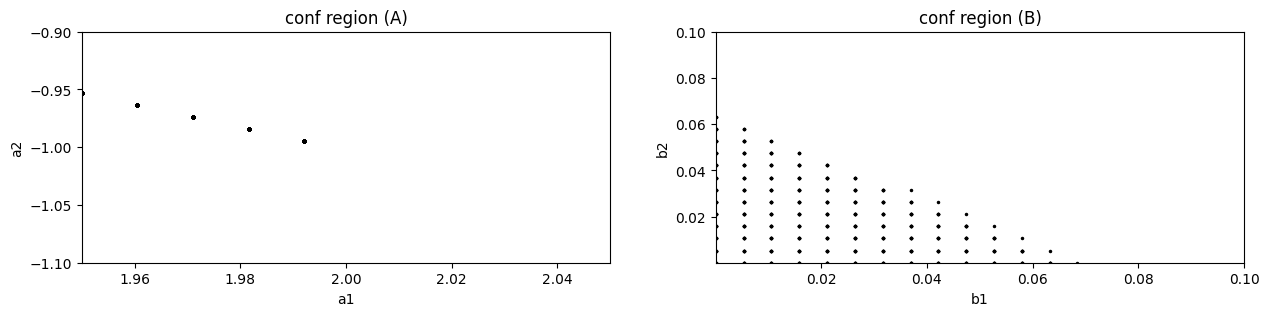

In [7]:
pts = sample_fused_rank_tensor(conf_region1, grid_axes, 0.95)

fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,3))
plot_pts_in_conf_region(pts, 0, 1, fig=fig, ax=axes[0])
plot_pts_in_conf_region(pts, 2, 3, fig=fig, ax=axes[1])
axes[0].set_xlim(search_ranges[0])
axes[0].set_ylim(search_ranges[1])
axes[1].set_xlim(search_ranges[2])
axes[1].set_ylim(search_ranges[3])
axes[0].set_title('conf region (A)')
axes[1].set_title('conf region (B)')
axes[0].set_xlabel('a1')
axes[0].set_ylabel('a2')
axes[1].set_xlabel('b1')
axes[1].set_ylabel('b2')
plt.show()

In [8]:
n = pts.shape[0]

Alist = np.zeros((n,2,2))
Blist = np.zeros((n,2,1))
Clist = np.zeros((n,1,2))
for i in range(n):
    A,B,C = tf_to_ocf([0,-pts[i,0],-pts[i,1]], den=[1,pts[i,2],pts[i,3]])
    Alist[i] = A
    Blist[i] = B
    Clist[i] = C

In [9]:
# ~~~~~~~~~~~~~~~~~~~~~~~ compute the new min-max optimal controller

Q = np.array([[1, 0], [0, 1]])
R = np.array(1)

ocSolver = OptimalControlSolver(Alist,Blist)
ocSolver.Q = Q
ocSolver.R = R
ocSolver.solve(method='LMI')

K = ocSolver.K_opt

INFO:optimal_controller.optimal_controls: Convex hull of A set has 14 vertices
INFO:optimal_controller.optimal_controls: Convex hull of B set has 15 vertices
INFO:optimal_controller.optimal_controls: This will lead to 210 LMI constraints
INFO:optimal_controller.optimal_controls: Defined 210 LMI constraints
INFO:optimal_controller.optimal_controls: SolutionStatus.Optimal, simultaneously stabilising feedback gain is K = [[-0.396  0.003]]
c:\Users\conor\anaconda3\envs\capstone_v2\lib\site-packages\scipy\optimize\_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
INFO:optimal_controller.optimal_controls: Optimised the simultaneously stabilising feedback gain, yielding K = [[-0.317  0.000]]
INFO:optimal_controller.optimal_controls: Worst J using initial K: 2.4233
INFO:optimal_controller.optimal_controls: Worst J using optimized K: 2.3728


         Current function value: 2.371664
         Iterations: 6
         Function evaluations: 243
         Gradient evaluations: 77


In [10]:
n = pts.shape[0]

Aduallist = np.zeros((n,2,2))
Bduallist = np.zeros((n,2,1))
for i in range(n):
    A, B, _ = tf_to_ocf([0,-pts[i,0],-pts[i,1]], den=[1,pts[i,2],pts[i,3]])
    Aduallist[i] = A.T
    Bduallist[i] = C.T

U = np.eye(2)
V = 1

ocSolver = OptimalControlSolver(Aduallist,Bduallist)
ocSolver.Q = U
ocSolver.R = V
ocSolver.solve(method='LMI')

INFO:optimal_controller.optimal_controls: Convex hull of A set has 14 vertices
INFO:optimal_controller.optimal_controls: Convex hull of B set has 1 vertices
INFO:optimal_controller.optimal_controls: This will lead to 14 LMI constraints
INFO:optimal_controller.optimal_controls: Defined 14 LMI constraints
INFO:optimal_controller.optimal_controls: SolutionStatus.Optimal, simultaneously stabilising feedback gain is K = [[-0.022 -0.021]]
INFO:optimal_controller.optimal_controls: Optimised the simultaneously stabilising feedback gain, yielding K = [[0.000 0.000]]


Optimization terminated successfully.
         Current function value: 3.000002
         Iterations: 2
         Function evaluations: 15
         Gradient evaluations: 5


INFO:optimal_controller.optimal_controls: Worst J using initial K: 3.0090
INFO:optimal_controller.optimal_controls: Worst J using optimized K: 3.0163


In [ ]:
# Now need to simulate the system, with the observer + full state feedback controller in the loop


array([[0.000],
       [1.000]])

In [3]:
# Alright how can I neaten this up

# Ideally, workflow should look like this

# Main loop
    # simulate integrator-augmented ARX system for 100 samples, get the control and state timeseries
    # compute the cost J
    # compute the confidence region for the ARX params
    # fuse with the previous confidence region
    # compute the optimal K (designed for an integrator-augmented system)
    # store all results

# Plot results
    # How K changed over time
    # How confidence region changed over time
    # Ultimately, how J changed over time

##### Define an ARX system, generate input/output data

In [4]:
n_a = 1
n_b = 1

search_ranges = [[0.1, 1.0], [0.1, 1.0]] # a range, b range
search_resolutions = [20,20]
grid_axes = [np.linspace(search_ranges[i][0], search_ranges[i][1], search_resolutions[i]) for i in range(n_a+n_b)]
grid_axes = np.array(grid_axes)
grid_vals = np.meshgrid(*grid_axes, indexing='ij')
grid_vals = np.array(grid_vals)

a = 0.8
b = 0.5
A = [1, -a]
B = [b]
C = [1, 0.15]

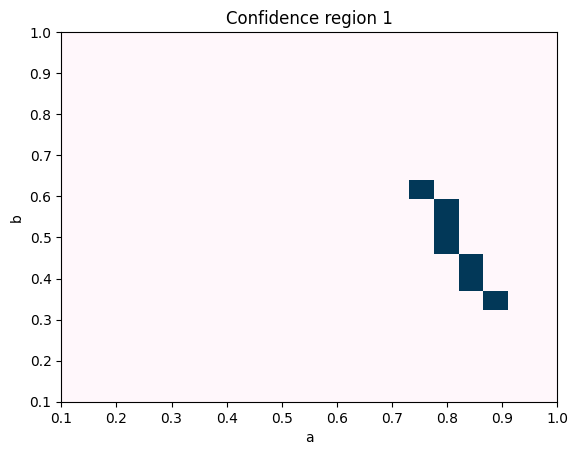

INFO:optimal_controller.optimal_controls: Convex hull of A set has 2 vertices
INFO:optimal_controller.optimal_controls: Convex hull of B set has 2 vertices
INFO:optimal_controller.optimal_controls: This will lead to 4 LMI constraints
INFO:optimal_controller.optimal_controls: Defined 4 LMI constraints
INFO:optimal_controller.optimal_controls: SolutionStatus.Optimal, simultaneously stabilising feedback gain is K = [[1.245]]
INFO:optimal_controller.optimal_controls: Optimised the simultaneously stabilising feedback gain, yielding K = [[0.131]]
INFO:optimal_controller.optimal_controls: Worst J using initial K: 21.6016
INFO:optimal_controller.optimal_controls: Worst J using optimized K: 4.5333


In [5]:
n_samples = 200
k = 0

for i in range(1):
    F = [k]
    L = [1]
    armax_model = ARMAX(A, B, C, F, L)
    R = np.sign(np.sin(np.linspace(0, 10*np.pi, n_samples))) # square wave
    Y, U, N, R = armax_model.simulate(n_samples, R, noise_std=0.2)

    F = ([k], [1])
    L = ([1], [1])
    m = 20
    q = 1
    model = SPS_indirect_model(m, q)
    conf_region1 = get_ranks(grid_axes, model, n_a, n_b, C, L, F, Y, R)

    fig, ax = plt.subplots(1,1)
    ax.set_title("Confidence region 1")
    ax.imshow(conf_region1.T < 1 - 1/20, cmap="PuBu", origin="lower", extent=search_ranges[0]+search_ranges[1])
    ax.set_aspect('auto')
    ax.set_xlabel('a')
    ax.set_ylabel('b')
    plt.show()

    # For a first order system, the A and B are just the SPS-identified scalars
    params_in_conf_region = grid_vals[:, conf_region1 < (1 - 1/20)]
    a_in_set = params_in_conf_region[0,:]
    b_in_set = params_in_conf_region[1,:]

    k = get_optimal_controller(a_in_set,b_in_set,method='LMI',Q=1,R=10)
    k = k.squeeze()

In [6]:
# ~~~~~~~~~~~~~~~~~~~~~~~ augment the system with an integrator

C_r = 1

A_set = []
B_set = []
n_plants = a_in_set.shape[0]
for i in range(n_plants):
    A_set.append([[a_in_set[i], 0], [-C_r, 1]])
    B_set.append([[b_in_set[i]], [0]])

A_set = np.array(A_set)
B_set = np.array(B_set)

In [33]:
A_set

[[[[[[],
     array([[1.489, 0.101],
            [0.101, 1.599]])],
    array([[1.508, 0.086],
           [0.100, 1.611]])],
   array([[1.513, 0.113],
          [0.097, 1.592]])],
  array([[1.496, 0.100],
         [0.099, 1.595]])],
 array([[1.498, 0.102],
        [0.092, 1.594]])]

In [7]:
# ~~~~~~~~~~~~~~~~~~~~~~~ compute the new min-max optimal controller

Q = np.array([[1, 0], [0, 1]])
R = np.array(1)

ocSolver = OptimalControlSolver(A_set,B_set)
ocSolver.Q = Q
ocSolver.R = R
ocSolver.solve(method='LMI')
K = ocSolver.K_opt

INFO:optimal_controller.optimal_controls: Convex hull of A set has 2 vertices
INFO:optimal_controller.optimal_controls: Convex hull of B set has 2 vertices
INFO:optimal_controller.optimal_controls: This will lead to 4 LMI constraints
INFO:optimal_controller.optimal_controls: Defined 4 LMI constraints
INFO:optimal_controller.optimal_controls: SolutionStatus.Optimal, simultaneously stabilising feedback gain is K = [[ 2.397 -0.923]]
INFO:optimal_controller.optimal_controls: Optimised the simultaneously stabilising feedback gain, yielding K = [[ 2.172 -0.659]]
INFO:optimal_controller.optimal_controls: Worst J using initial K: 15.7614
INFO:optimal_controller.optimal_controls: Worst J using optimized K: 15.0380


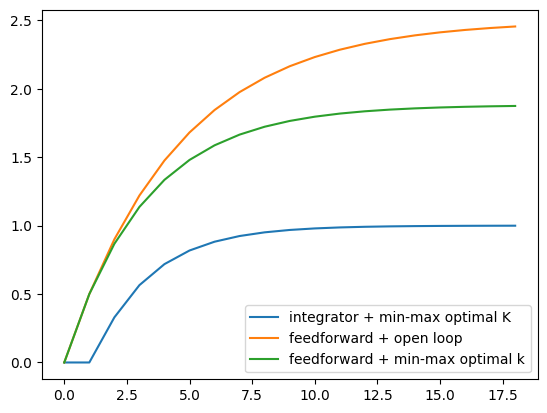

In [8]:
from scipy import signal

Ts = 1.0
N  = 20
tspan  = np.arange(N) * Ts

t_plot = -1

C_r = 1
B_i = np.array([[0], [1]])
C_i = np.array([[C_r, 0]])
D_i = np.array([[0]])

A_aug = np.array([[a, 0], [-C_r, 1]])
B_aug = np.array([[b], [0]])
A_i = A_aug - B_aug @ K
t, y = signal.dstep((A_i, B_i, C_i, D_i, Ts), t=tspan)
plt.plot(t[:t_plot], np.squeeze(y)[:t_plot], label='integrator + min-max optimal K')

t, y = signal.dstep((a, b, 1, 0, Ts), t=tspan)
plt.plot(t[:t_plot], np.squeeze(y)[:t_plot], label='feedforward + open loop')

t, y = signal.dstep((a-b*k, b, 1, 0, Ts), t=tspan)
plt.plot(t[:t_plot], np.squeeze(y)[:t_plot], label='feedforward + min-max optimal k')

plt.legend()
plt.show()

In [29]:
np.random.seed(42)
A_set = np.zeros((5,2,2))
for i in range(5):
    A_set[i] = np.array([[1,0.5], [0.5,1]]) + 0.33*np.random.randn(2,2)

B_set = np.zeros((5,2,2))
for i in range(5):
    B_set[i] = np.eye(2) + 0.33*np.random.randn(2,2)

ocSolver = OptimalControlSolver(A_set,B_set)
ocSolver.Q = np.eye(2)
ocSolver.R = np.eye(2)
ocSolver.solve(method='LMI')
K = ocSolver.K_opt

INFO:optimal_controller.optimal_controls: Convex hull of A set has 5 vertices
INFO:optimal_controller.optimal_controls: Convex hull of B set has 5 vertices
INFO:optimal_controller.optimal_controls: This will lead to 25 LMI constraints
INFO:optimal_controller.optimal_controls: Defined 25 LMI constraints
INFO:optimal_controller.optimal_controls: SolutionStatus.Optimal, simultaneously stabilising feedback gain is K = [[0.904 1.103]
 [0.552 0.882]]
INFO:optimal_controller.optimal_controls: Optimised the simultaneously stabilising feedback gain, yielding K = [[1.118 0.709]
 [0.292 1.089]]
INFO:optimal_controller.optimal_controls: Worst J using initial K: 27.6926
INFO:optimal_controller.optimal_controls: Worst J using optimized K: 9.0349


R^{-1/2} thing

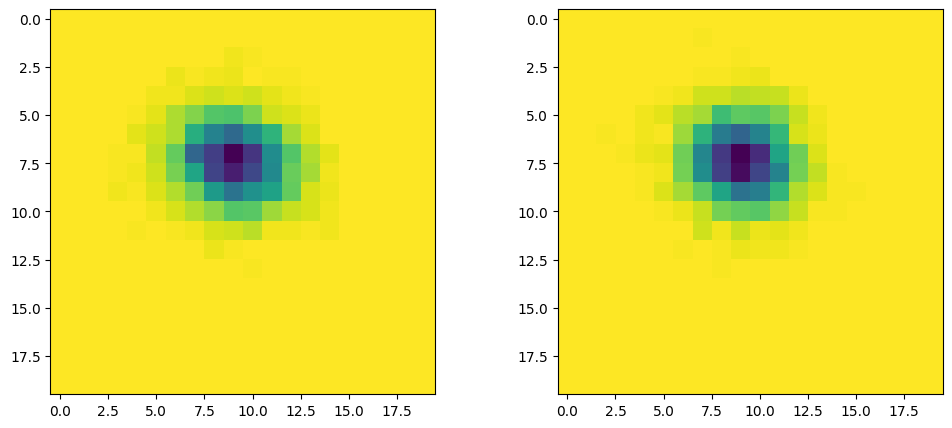

In [9]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# System: x_{k+1} = theta1 * x_k + theta2 * u_k + noise
true_theta = np.array([0.5, 0.8])
n = 100  # number of samples
d = 2    # dimension of theta
alpha = 0.05  # 95% confidence -> 5% significance
M = 100  # number of sign perturbations

# Generate synthetic input/output data
x_k = np.zeros(n)
u_k = np.random.randn(n)
noise = np.random.randn(n) * 0.3
y_k = np.zeros(n)

for k in range(n - 1):
    y_k[k + 1] = true_theta[0] * x_k[k] + true_theta[1] * u_k[k] + noise[k]
    x_k[k + 1] = y_k[k + 1]

# Build regressors and outputs
phi = np.column_stack((x_k[:-1], u_k[:-1]))  # shape (n-1, 2)
y = y_k[1:]  # shape (n-1,)

# Compute empirical covariance
R_n = (phi.T @ phi) / (n - 1)
R_n_inv_sqrt = np.linalg.inv(np.linalg.cholesky(R_n)).T

# Nominal SPS sum (no sign)
S_nom = lambda theta: (phi * (y - phi @ theta)[:, None]).mean(axis=0)

# SPS with random signs
def SPS_norms(theta, whiten=True):
    norms = []
    for _ in range(M - 1):
        alpha = np.random.choice([-1, 1], size=n - 1)
        perturbed = phi * (alpha * (y - phi @ theta))[:, None]
        sum_ = perturbed.mean(axis=0)
        if whiten:
            sum_ = R_n_inv_sqrt @ sum_
        norms.append(np.linalg.norm(sum_))
    # Add nominal (no sign)
    s0 = S_nom(theta)
    if whiten:
        s0 = R_n_inv_sqrt @ s0
    norms.append(np.linalg.norm(s0))
    return norms

# SPS confidence region grid
theta1_vals = np.linspace(0.3, 0.7, 20)
theta2_vals = np.linspace(0.6, 1.0, 20)
T1, T2 = np.meshgrid(theta1_vals, theta2_vals)
inside_whitened = np.zeros_like(T1, dtype=bool)
inside_unwhitened = np.zeros_like(T1, dtype=bool)
ranks_whitened = np.zeros_like(T1)
ranks_unwhitened = np.zeros_like(T1)

for i in range(T1.shape[0]):
    for j in range(T1.shape[1]):
        theta = np.array([T1[i, j], T2[i, j]])
        norms_w = SPS_norms(theta, whiten=True)
        norms_uw = SPS_norms(theta, whiten=False)
        rank_w = sum(norm < norms_w[-1] for norm in norms_w)
        rank_uw = sum(norm < norms_uw[-1] for norm in norms_uw)
        inside_whitened[i, j] = rank_w >= int((1 - alpha) * M)
        inside_unwhitened[i, j] = rank_uw >= int((1 - alpha) * M)
        ranks_whitened[i, j] = rank_w
        ranks_unwhitened[i, j] = rank_uw

# Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(ranks_unwhitened)
axs[1].imshow(ranks_whitened)
plt.show()

